In [28]:
import numpy as np
import pandas as pd 
import os 
import tensorflow as tf 
import warnings 
warnings.filterwarnings('ignore')

In [29]:
df=pd.read_csv('../skin_disease/GroundTruth.csv')
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
label_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
label_names = sorted(label_names)
label_names

['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

In [31]:
df['image']=df['image'].apply(lambda x: x+ '.jpg')

In [32]:
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
import shutil
data_dir = '../skin_disease/working/lesions'

# Empty directory to prevent FileExistsError if the function is run several times
if os.path.exists(data_dir):
  shutil.rmtree(data_dir)

# Create the empty dir for each skin lesion
for label in label_names:
    os.makedirs(os.path.join(data_dir, label)) 


In [34]:
from shutil import copyfile
from tqdm import tqdm
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc=f'Copying HAM10000 dataset images..'):
    image_name = row['image']  
    hot_label = row[row == 1].index.tolist()[0]  
    src_path = os.path.join("../skin_disease/images", image_name)
    dst_path = os.path.join(data_dir, hot_label, image_name)
    copyfile(src_path, dst_path)

Copying HAM10000 dataset images..: 100%|██████████| 10015/10015 [01:20<00:00, 125.16it/s]


In [35]:
tot = 0
for label in label_names:
    cnt_label = len(os.listdir(os.path.join(data_dir, label)))
    print(f"There are {cnt_label} images with label {label}.")
    tot += cnt_label
print(f"\nThere are {tot} total images across all labels.")

There are 327 images with label AKIEC.
There are 514 images with label BCC.
There are 1099 images with label BKL.
There are 115 images with label DF.
There are 1113 images with label MEL.
There are 6705 images with label NV.
There are 142 images with label VASC.

There are 10015 total images across all labels.


In [36]:
label_names.append('BENIGN')
label_names = sorted(label_names)
label_names

['AKIEC', 'BCC', 'BENIGN', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

In [37]:
os.makedirs(os.path.join(data_dir, 'BENIGN'))

In [38]:
# Iterate over the new dataset and copy only the Benign images
benign_paths = ["../skin_disease/test/Benign", "../skin_disease/train/Benign"]

for directory_path in benign_paths:
    files_and_directories = os.listdir(directory_path)
    only_files = [f for f in files_and_directories if os.path.isfile(os.path.join(directory_path, f))]
    for image_name in tqdm(only_files, desc=f'Copying dataset2 benign images..'):
        src_path = os.path.join(directory_path, image_name)
        dst_path = os.path.join(data_dir, 'BENIGN', image_name)
        copyfile(src_path, dst_path)

Copying dataset2 benign images..: 100%|██████████| 6289/6289 [00:33<00:00, 186.09it/s]


In [39]:
tot = 0
for label in label_names:
    cnt_label = len(os.listdir(os.path.join(data_dir, label)))
    print(f"There are {cnt_label} images with label {label}.")
    tot += cnt_label
print(f"\nThere are {tot} total images across all labels.")

There are 327 images with label AKIEC.
There are 514 images with label BCC.
There are 7289 images with label BENIGN.
There are 1099 images with label BKL.
There are 115 images with label DF.
There are 1113 images with label MEL.
There are 6705 images with label NV.
There are 142 images with label VASC.

There are 17304 total images across all labels.


In [40]:
# Start weights at zero
num_classes = len(label_names)
weights = [0] * num_classes 
tot = 0
for idx, label in enumerate(label_names):
    cnt_label = len(os.listdir(os.path.join(data_dir, label)))
    weights[idx] = cnt_label  
    tot += cnt_label
class_frequencies = weights
class_frequencies = [ w / tot for w in weights ] 
weights = [ 1.0 / cnt for cnt in weights ]
weights = [ tot * w / num_classes for w in weights ]
class_weight = {}
for i in range(num_classes):
    class_weight[i] = weights[i]
    print(f"Weight for class {i}: " + '{:.2f}'.format(weights[i]))

Weight for class 0: 6.61
Weight for class 1: 4.21
Weight for class 2: 0.30
Weight for class 3: 1.97
Weight for class 4: 18.81
Weight for class 5: 1.94
Weight for class 6: 0.32
Weight for class 7: 15.23


In [41]:
both_paths = ["../skin_disease/working/lesions/MEL", "../skin_disease/working/lesions/BENIGN"]

for directory_path in both_paths:
    
    print(f"Image path: {directory_path}")
    files_and_directories = os.listdir(directory_path)
    only_files = [f for f in files_and_directories if os.path.isfile(os.path.join(directory_path, f))]
    
    only_files = only_files[:5]
    for image_name in only_files:
        
        image_path = os.path.join(directory_path, image_name)
        
        img = tf.keras.utils.load_img(image_path)
        print(f"Image shape: {img.size}")

Image path: ../skin_disease/working/lesions/MEL
Image shape: (600, 450)
Image shape: (600, 450)
Image shape: (600, 450)
Image shape: (600, 450)
Image shape: (600, 450)
Image path: ../skin_disease/working/lesions/BENIGN
Image shape: (224, 224)
Image shape: (224, 224)
Image shape: (224, 224)
Image shape: (224, 224)
Image shape: (224, 224)


In [42]:
IMG_SIZE=224
BATCH_SIZE=32
train_ds, val_and_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",   
    class_names=label_names,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=7,
    validation_split=0.2,       
    subset="both",              
    crop_to_aspect_ratio=True,
)

Found 17304 files belonging to 8 classes.
Using 13844 files for training.
Using 3460 files for validation.


In [43]:
val_and_test_ds_size = len(list(val_and_test_ds))

# Calculate the number of samples for each split
val_size = int(val_and_test_ds_size * 0.5)
test_size = val_and_test_ds_size - val_size

# Split the dataset
val_ds = val_and_test_ds.take(val_size)
test_ds = val_and_test_ds.skip(val_size)

In [44]:
for images_batch, labels_batch in test_ds.take(1):
    print(images_batch.shape)
    print(labels_batch.shape)

(32, 224, 224, 3)
(32, 8)


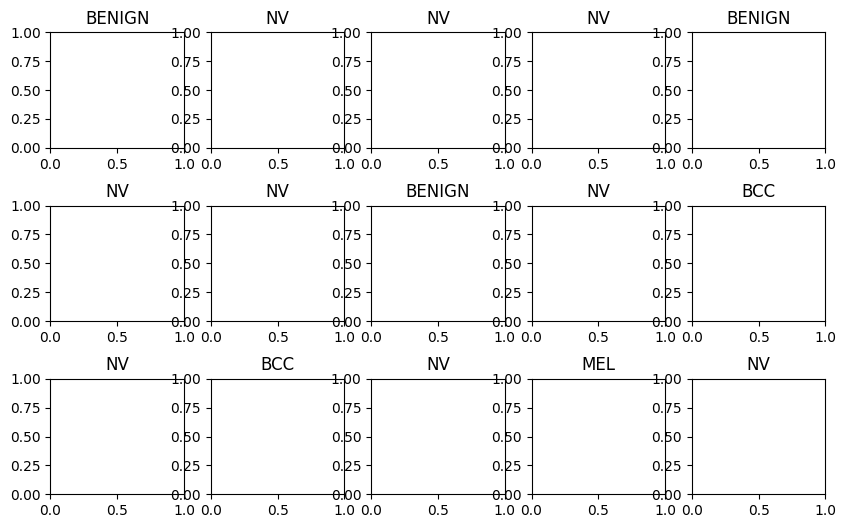

In [45]:
import matplotlib.pyplot as plt

n_rows = 3
n_cols = 5

plt.figure(figsize=(n_cols * 2.0, n_rows * 2.0))

# Get a batch to work with
for images_batch, labels_batch in train_ds.take(1):
    pass

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        img = images_batch[index, :, :, :].numpy()
        label_row = labels_batch[index, :]
        class_label = tf.argmax(label_row).numpy()
        
        class_label = label_names[class_label]
        plt.title(class_label)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [46]:
image_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomRotation(factor=0.15),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=7),
])

In [47]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [50]:
METRICS = [
    tf.keras.metrics.CategoricalCrossentropy(name='categorical_crossentropy'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.F1Score(name='f1'),
    tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),  
]

def build_model(num_classes, metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    aug_inputs = image_augmentation(inputs)
    model = tf.keras.applications.EfficientNetB0(include_top=False, input_tensor=aug_inputs, weights="imagenet")

    model.trainable = False
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, 
                                    activation="softmax",
                                    bias_initializer=output_bias,
                                    name="pred")(x)

    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=metrics,
    )
    
    return model
model = build_model(num_classes)
model.summary()

16705208/16705208 [==============================] - 17s 1us/step
Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['sequential[0][0]']          
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                 

In [51]:
for image_batch, label_batch in train_ds.take(1):
    pass

results = model.evaluate(image_batch, label_batch, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 2.3457


Since our dataset is imbalanced, the bias in the final classifier should not be set to 0.

Because it is, then the default loss in the final softmax layer should be -log(1/n_classes) (predicts them with equal probabilities) or -log(1/8) here (where log is natural log). Which is a loss of 2.079. This is pretty close to what we measured above.

In a multi-class classification scenario using neural networks, the final layer often consists of a fully connected (dense) layer followed by a softmax activation function. Each neuron in this dense layer corresponds to a class. Adjusting the bias terms for each class can help in dealing with class imbalance by influencing the initial predictions of the model before training starts.

When you initialize the biases to reflect the class distribution, you're essentially providing the model with a prior that matches your data distribution, which can lead to faster convergence and potentially better initial accuracy. It won't affect our final results, but will save some training time instead of using the first several epochs to just learn better bias settings.

One approach to setting these biases for a multi-class classification problem is to use the log odds of the class frequencies. Suppose you have a dataset with N classes, and the fraction of the dataset belonging to class i is fi. You can set the initial bias bi for the neuron corresponding to class i as follows:

bi = log(fi / (1-fi))

where fi is the fraction of the training set belonging to class i and log is the natural logarithm, ln. This formula comes from the logistic regression setting, where the log odds can represent the bias term for imbalanced classes.

In [52]:
class_frequencies = np.array(class_frequencies)

# Making priors that match the data distribution for faster convergence
class_log_odds = np.log(class_frequencies / (1 - class_frequencies))

print(class_log_odds)

[-3.94965459 -3.48631548 -0.31771761 -2.69091916 -5.00709279 -2.67739646
 -0.45790614 -4.79462586]


In [53]:
model = build_model(num_classes, output_bias=class_log_odds)
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['sequential[1][0]']          
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                 

In [54]:
results = model.evaluate(image_batch, label_batch, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.2705


In [56]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)
reduce_lr_on_plateau_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,         
    patience=3,         
    verbose=1,          
)

In [58]:
EPOCHS=99
history = model.fit(train_ds, 
                    epochs=EPOCHS, 
                    validation_data=val_ds,
                    class_weight=class_weight,  
                    callbacks=[early_stopping_cb, reduce_lr_on_plateau_cb],
                   )

Epoch 1/99
433/433 [==============================] - 906s 2s/step - loss: 3.6070 - categorical_crossentropy: 2.5198 - tp: 7880.0000 - tn: 91563.0000 - fp: 5345.0000 - fn: 5964.0000 - precision: 0.5958 - recall: 0.5692 - f1: 0.3439 - categorical_accuracy: 0.5814 - val_loss: 1.5423 - val_categorical_crossentropy: 1.5423 - val_tp: 1129.0000 - val_tn: 11550.0000 - val_fp: 546.0000 - val_fn: 599.0000 - val_precision: 0.6740 - val_recall: 0.6534 - val_f1: 0.4034 - val_categorical_accuracy: 0.6597 - lr: 0.0100
Epoch 2/99
163/433 [==========>...................] - ETA: 7:49 - loss: 2.7247 - categorical_crossentropy: 2.0566 - tp: 3314.0000 - tn: 34765.0000 - fp: 1747.0000 - fn: 1902.0000 - precision: 0.6548 - recall: 0.6354 - f1: 0.4057 - categorical_accuracy: 0.6428

In [ ]:
def plot_history(history):
    fig, ax = plt.subplots(2,1)
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
def unfreeze_model(model, metrics=METRICS):
    
#     We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    # Unfreeze all the layers, but leave BatchNorm layers frozen
#     for layer in model.layers[-20:]:
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    # Use a much smaller learning rate now to start
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    
    # Recompile to 'freeze' which layers are frozen (not trainable)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=metrics
    )

unfreeze_model(model)